In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations, draw_fft
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)


pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [2]:
N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01

In [3]:
# 多时间序列采样
T=5
batch = 1000
t_list = []
x_data = []
for seed in range(batch):
    x_train, theta_hist, t_train, K_matrix = generate_kuramoto_cluster_data_sin_cos(
        N=N, n_clusters=n_clusters, K_intra=K_intra, K_inter=K_inter, dt=dt, T=T, noise=noise, random_seed1=42, random_seed2=seed
    )
    x_data.append(x_train)
    t_list.append(t_train)

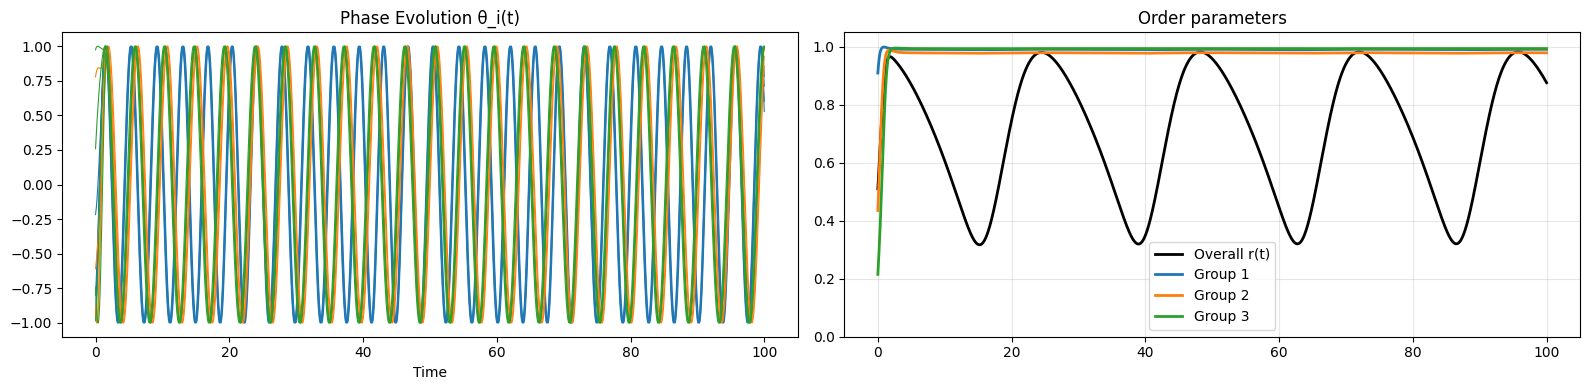

In [4]:
# 单时间序列采样
x_train, theta_hist, t_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_data = x_train


# 选择library

In [5]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
library_functions = [
    lambda x: x,
    # lambda x: np.sin(x),
    # lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide + fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(10000, 72)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'sin(1 x3)', 'cos(1 x3)', 'sin(1 x4)', 'cos(1 x4)', 'sin(1 x5)', 'cos(1 x5)', 'sin(1 x6)', 'cos(1 x6)', 'sin(1 x7)', 'cos(1 x7)', 'sin(1 x8)', 'cos(1 x8)', 'sin(1 x9)', 'cos(1 x9)', 'sin(1 x10)', 'cos(1 x10)', 'sin(1 x11)', 'cos(1 x11)', 'sin(1 x12)', 'cos(1 x12)', 'sin(1 x13)', 'cos(1 x13)', 'sin(1 x14)', 'cos(1 x14)', 'sin(1 x15)', 'cos(1 x15)', 'sin(1 x16)', 'cos(1 x16)', 'sin(1 x17)', 'cos(1 x17)', 'sin(1 x18)', 'cos(1 x18)', 'sin(1 x19)', 'cos(1 x19)', 'sin(1 x20)', 'cos(1 x20)', 'sin(1 x21)', 'cos(1 x21)', 'sin(1 x22)', 'cos(1 x22)', 'sin(1 x23)', 'cos(1 x23)']


# 进行拟合

In [6]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=False

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l1")
lasso_optimizer = Lasso(alpha=0.01, max_iter=20000, fit_intercept=False)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)' = 0.013 x8 + -1.563 x12 + -0.006 x13 + -0.032 x14 + -0.054 x15
(x1)' = 0.079 x3 + 0.012 x9 + -0.868 x13 + -0.746 x14
(x2)' = 0.007 x6 + -1.648 x14
(x3)' = 0.014 x8 + -0.017 x12 + -1.638 x15
(x4)' = 0.003 x3 + -1.397 x16
(x5)' = 0.001 x2 + 0.103 x11 + -0.922 x17 + -0.073 x18 + -0.326 x19
(x6)' = 0.003 x3 + -0.038 x16 + -0.021 x17 + -1.337 x18
(x7)' = 0.133 x9 + -0.899 x19 + -0.450 x20
(x8)' = 0.001 x1 + -0.136 x18 + -1.133 x20 + -0.112 x21
(x9)' = 0.009 x3 + -0.003 x18 + -1.395 x21
(x10)' = -0.347 x20 + -0.126 x21 + -0.890 x22 + -0.019 x23
(x11)' = -1.394 x23
(x12)' = 1.652 x0 + 0.010 x22
(x13)' = 1.646 x1 + 0.010 x18
(x14)' = 0.017 x0 + 0.033 x1 + 1.599 x2 + 0.007 x18
(x15)' = 0.008 x0 + 1.645 x3 + 0.010 x22
(x16)' = 1.399 x4 + 0.004 x13 + 0.003 x15
(x17)' = 1.244 x5 + 0.129 x7 + 0.017 x23
(x18)' = 1.394 x6 + 0.002 x9 + 0.006 x13
(x19)' = 0.587 x5 + 0.569 x7 + 0.246 x9
(x20)' = -0.002 x3 + 0.084 x5 + 0.816 x8 + 0.480 x9
(x21)' = 1.400 x9 + 0.009 x15
(x22)' = 0.018 x4 + 0.887 x8 +

In [7]:
# 计算score
model.score(x_data_lift, t=dt)

0.9597190851873082

# 多步预测

/var/folders/h8/8tv4mdbs2sjgwbgd2gxhpdjm0000gn/T/ipykernel_26353/615257827.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


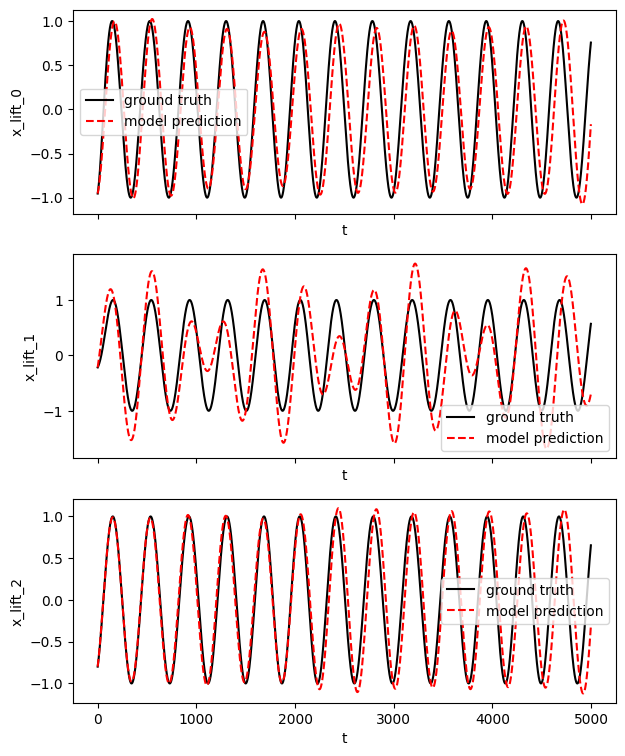

In [8]:
# 单时间序列
init_data = x_data_lift[0,:]
steps = 5000
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_train)-1)
else:
    X_data_predicted = model.simulate(init_data,t_train) 

# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:steps, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:steps, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

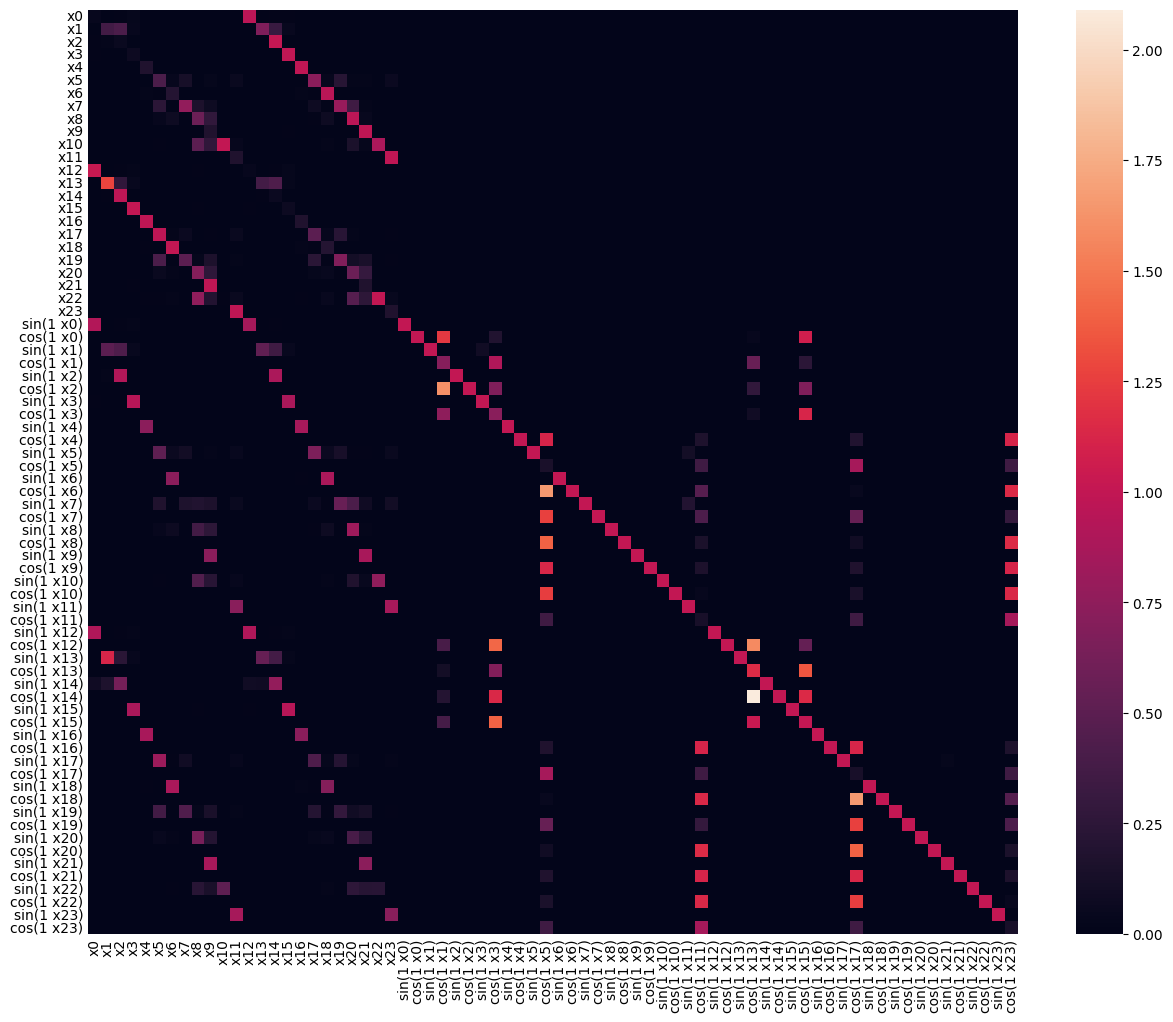

In [9]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(A), xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

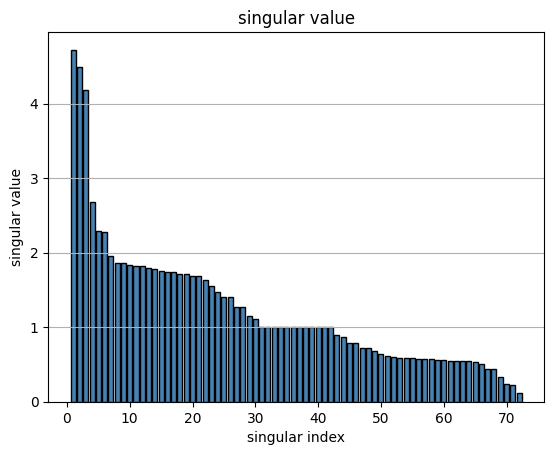

In [10]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

In [11]:
# 选取截断
rank = 3
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

3.2381409012028426


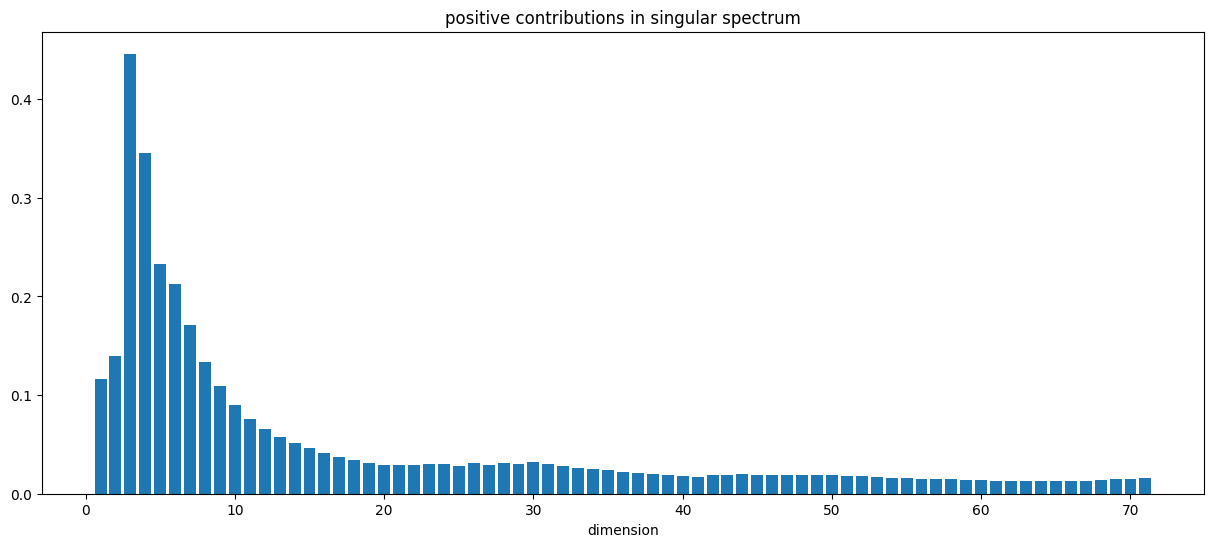

In [12]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [13]:
# 计算EC
print(compute_entropy(diff))

5.243596993387468


# 输出粗粒化表达式

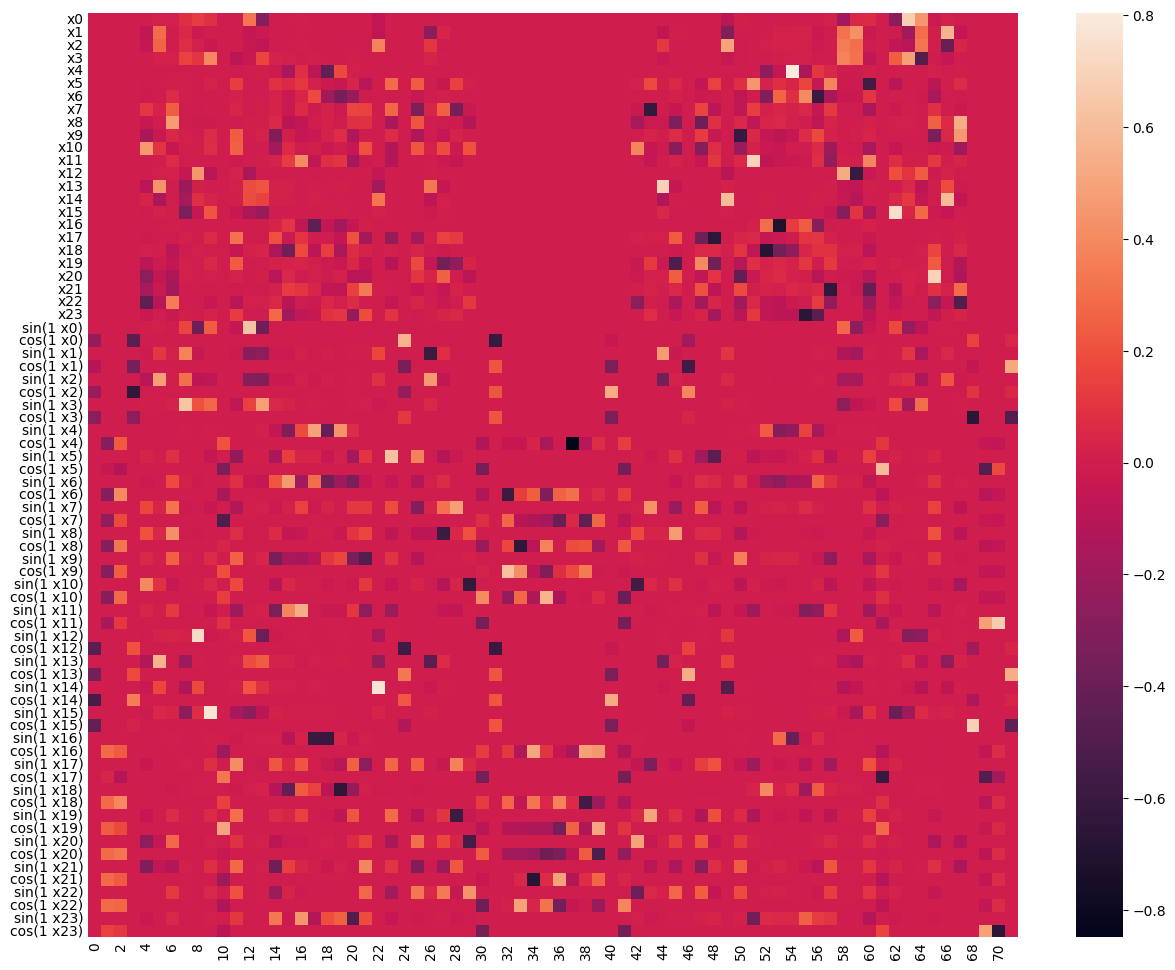

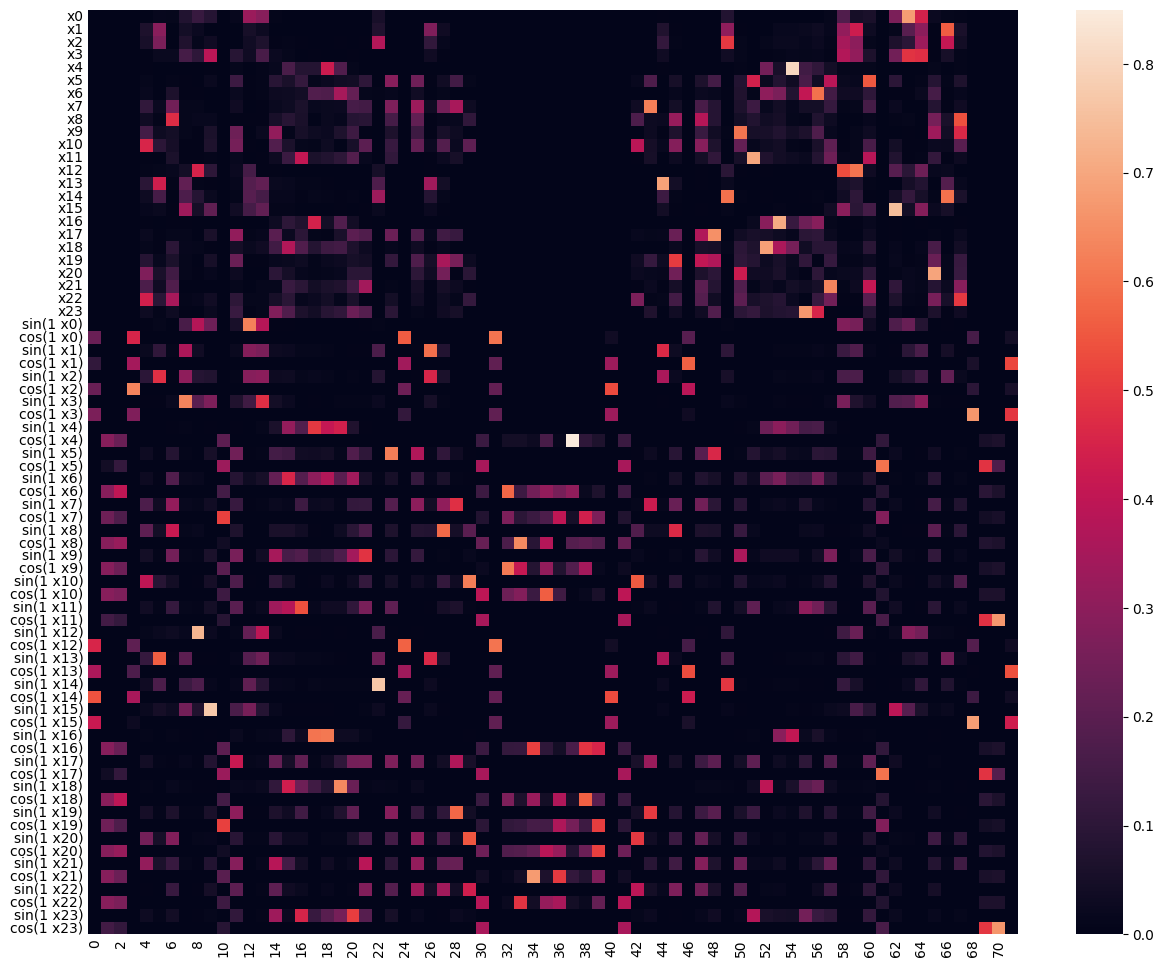

In [14]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

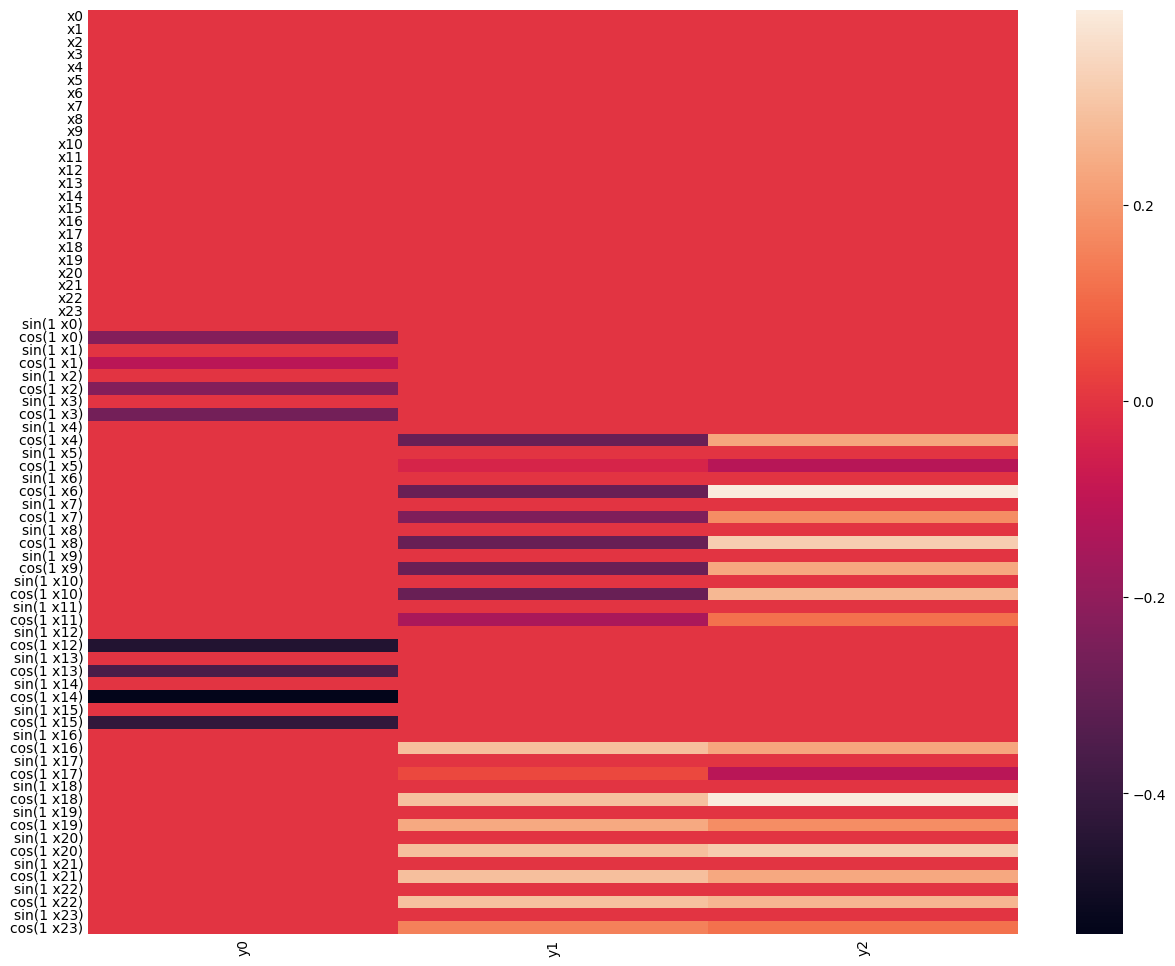

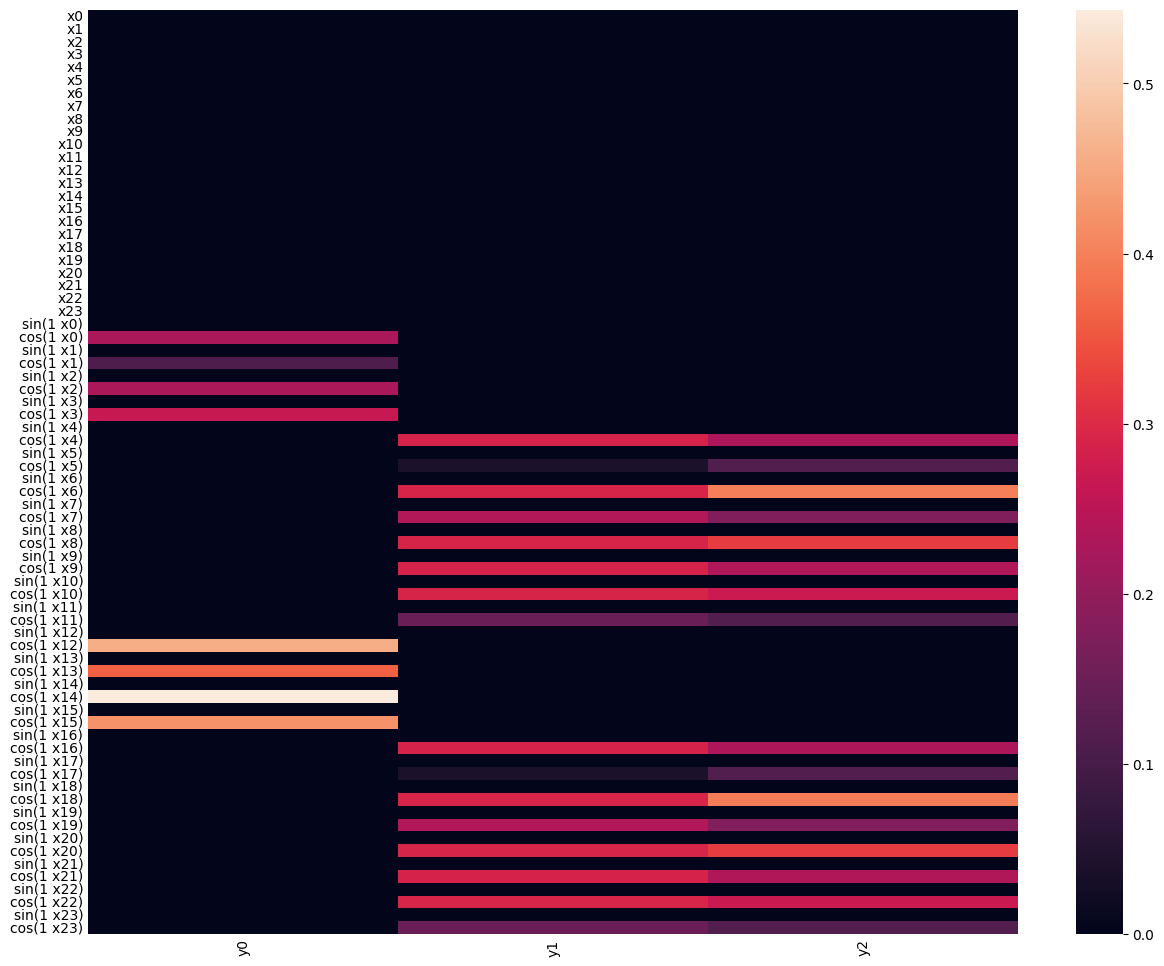

In [15]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [16]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = -0.2305 * cos(1 x0) - 0.1108 * cos(1 x1) - 0.2292 * cos(1 x2) - 0.2672 * cos(1 x3) - 0.4563 * cos(1 x12) - 0.3614 * cos(1 x13) - 0.5432 * cos(1 x14) - 0.4205 * cos(1 x15)
------------------------------
y1 = -0.2868 * cos(1 x4) - 0.0401 * cos(1 x5) - 0.2907 * cos(1 x6) - 0.2386 * cos(1 x7) - 0.2899 * cos(1 x8) - 0.2866 * cos(1 x9) - 0.2905 * cos(1 x10) - 0.1482 * cos(1 x11) + 0.2881 * cos(1 x16) + 0.0393 * cos(1 x17) + 0.2923 * cos(1 x18) + 0.2393 * cos(1 x19) + 0.2912 * cos(1 x20) + 0.2880 * cos(1 x21) + 0.2917 * cos(1 x22) + 0.1482 * cos(1 x23)
------------------------------
y2 = 0.2320 * cos(1 x4) - 0.1166 * cos(1 x5) + 0.3983 * cos(1 x6) + 0.1750 * cos(1 x7) + 0.3213 * cos(1 x8) + 0.2356 * cos(1 x9) + 0.2711 * cos(1 x10) + 0.1164 * cos(1 x11) + 0.2315 * cos(1 x16) - 0.1155 * cos(1 x17) + 0.3957 * cos(1 x18) + 0.1742 * cos(1 x19) + 0.3205 * cos(1 x20) + 0.2352 * cos(1 x21) + 0.2686 * cos(1 x22) + 0.1158 * cos(1 x23)
------------------------------


# 描述宏观演化

/var/folders/h8/8tv4mdbs2sjgwbgd2gxhpdjm0000gn/T/ipykernel_26353/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


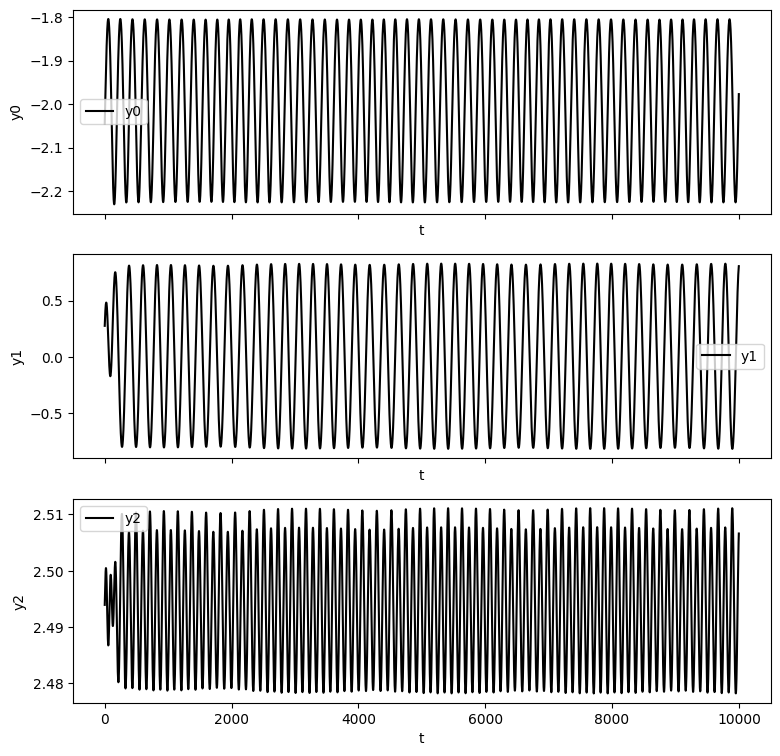

In [17]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [18]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = 1.2644 * y0[k]
------------------------------
y1[k+1] = 0.2642 * y1[k] + 0.0036 * y2[k]
------------------------------
y2[k+1] = 0.0004 * y1[k] + 1.8922 * y2[k]
------------------------------


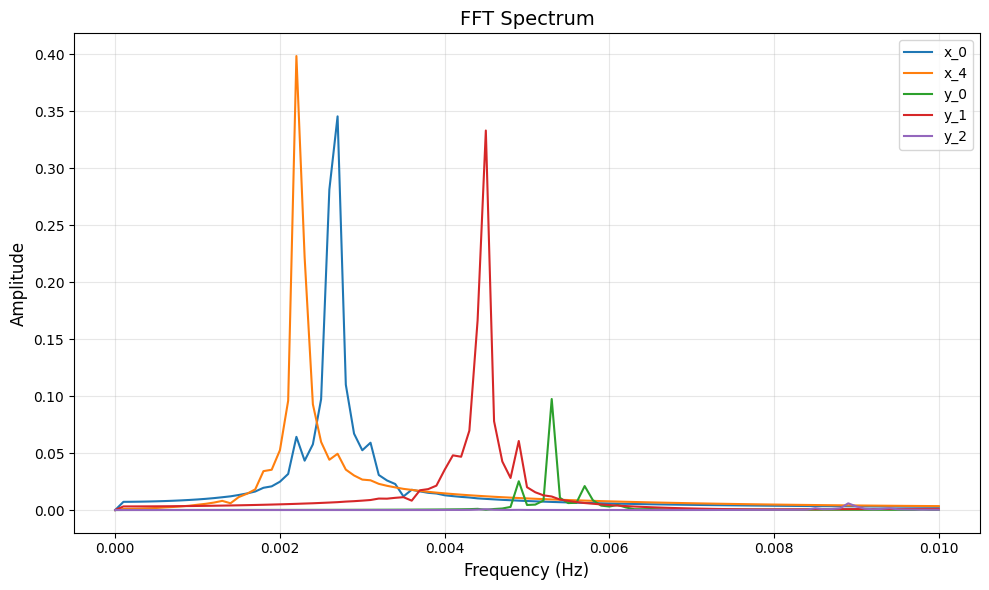

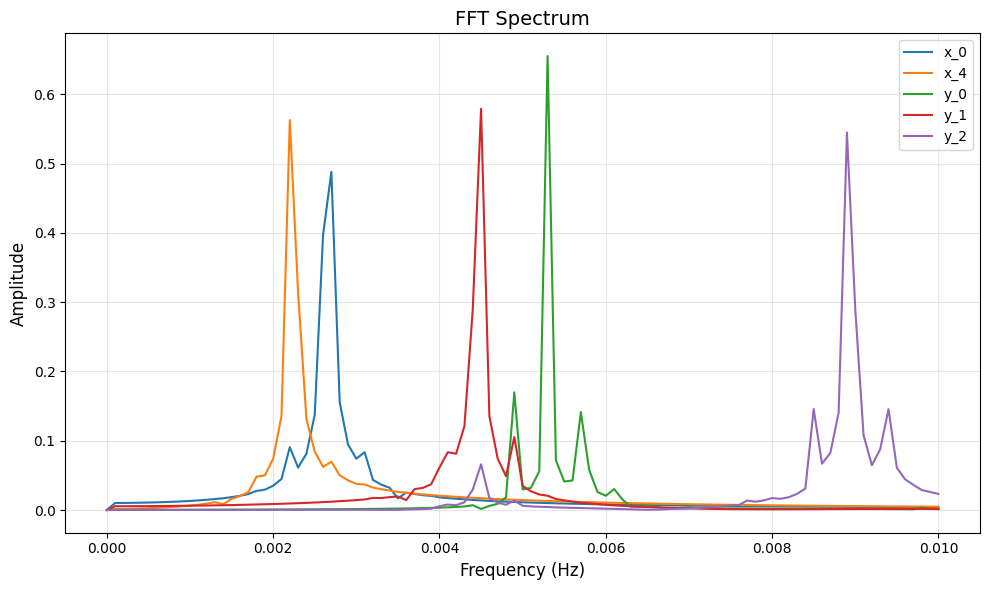

In [22]:
# 创建多列数据，每列不同频率
df_fft = pd.DataFrame({
    'x_0': x_data_lift[:,0],
    'x_4': x_data_lift[:,4],
    'y_0': macro_data[:, 0],
    'y_1': macro_data[:, 1],
    'y_2': macro_data[:, 2]
})

spec = draw_fft(df_fft, dt=0, max_f=0.01, normalize=False)
_ = draw_fft(df_fft, dt=0, max_f=0.01, normalize=True)